# Los Juncos Monitoring

Se monitorea la laguna *Los Juncos* en relacion a su falta de agua e intento de [recuperacion](https://www.bariloche2000.com/noticias/leer/los-amantes-de-las-aves-que-buscan-recuperar-una-laguna-que-ya-no-tiene-agua/134757).

La laguna se encuentra cercana a Dina Huapi (reactangulo negro).


![title](./data/los-juncos-perspective.png)

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import shutil
import matplotlib.pyplot as plt
#
#
import rasterio as rio
from rasterio import features
import rasterstats as rs
#
import shapely
import geopandas as gpd
#
from earthpy import plot
import seaborn as sns
#
from skimage.filters import threshold_otsu
import json
#
import warnings
#
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
from eo_forge.utils.raster_utils import write_mem_raster,write_raster
from eo_forge.utils.downloader import bucket_images_downloader,gcSatImg
from eo_forge.io.LandsatLoaders import LandsatLoader

In [3]:
import dask
from dask.distributed import Client, progress
from dask.delayed import delayed

In [65]:
def json_load(config_file):
    """"""
    with open(config_file) as fh:
        config = json.load(fh)
    return config

def datetime_to_str(date):
    return date.strftime('%Y-%m-%d')

def datetime_delta(date,delta_days):
    return (date-datetime.timedelta(days=delta_days))
    
def norm_to_median_mad(array,array_mask,nodata=0):
    """ normalize to mad an array
    Parameters
    ----------
        array: input array
        array_mask: mask array indicating valid values!
        nodata: value used as nodata
    
    """
    masked_array=array[array_mask]
    median=np.median(masked_array)
    mad=np.median(np.abs(masked_array-median))
    array_tmp=(array-median)/mad
    return np.where(array_mask,array_tmp,nodata)


def median_norm_raster_simple(raster,nodata=0,out=None,raster_open=False):
    """
    
    """
    profile=raster.profile.copy()
    data=[]
    for i in range(1,raster.count+1):
        array=raster.read(i)
        mask = (array==nodata)
        array_norm=norm_to_median_mad(array,~mask,nodata=nodata)
        data.append(array_norm)
        del array
        del array_norm
    data=np.array(data)
    if out is None:
        return write_mem_raster(data, **profile)
    else:
        raster=write_raster(out,data,**profile)
        if raster_open:
            return raster
        else:
            raster.close()
            return None

def ndi(b1,b2,nodata=0):
    ad=b1+b2
    di=b1-b2
    return np.where(ad==0,nodata,di/ad)

def compute_mndwi(raster,idx=[1,4],nodata=0):
    
    array=ndi(raster.read(idx[0]),raster.read(idx[1]),nodata)
    profile=raster.profile.copy()
    profile.update({ 
        "count":1,
        "nodata":nodata
      
    })
    return write_mem_raster(array[np.newaxis,...],**profile)

def compute_mask(raster,nodata=0):
    array=raster.read(1)
    mask=array==nodata
    threshold = threshold_otsu(array[~mask])
    cond=np.logical_and(array>threshold,~mask)
    mask_cp=np.where(cond,1,nodata).astype(rio.ubyte)
    profile=raster.profile.copy()
    profile.update({
        "dtype":rio.ubyte
    })
    return write_mem_raster(mask_cp[np.newaxis,...],**profile)


def compute_simple_mask(raster,nodata=0,threshold=0.27):
    array=raster.read(1)
    mask=array==nodata
    threshold = threshold
    cond=np.logical_and(array>threshold,~mask)
    mask_cp=np.where(cond,1,nodata).astype(rio.ubyte)
    profile=raster.profile.copy()
    profile.update({
        "dtype":rio.ubyte
    })
    return write_mem_raster(mask_cp[np.newaxis,...],**profile)


def mask_to_vector(raster, out_vector=None, driver="GPKG",return_open=False):
        """turn segmented mask into shapefile
        Parameters
        ----------
            out_vector: None or path
                if None return just in memory geodataframe instance
            driver: str
                driver to use for writting
        Returns
        -------
            geodataframe
        """
        raster_mask=raster.read(1)
        generator = features.shapes(
            (raster_mask * 1).astype(np.uint8),
            mask=raster_mask,
            transform=raster.transform,
        )
        geom_list = []
        
        for geom, value in generator:
            geom = shapely.geometry.shape(geom)
            geom_list.append([geom, value])
            
        gdf = gpd.GeoDataFrame(geom_list)
        gdf = gdf.rename(columns={0: "geometry", 1: "value"}).set_geometry(
            "geometry"
        )
        gdf.set_crs(raster.crs.to_epsg(),inplace=True,allow_override=True)
        
        if out_vector is None:
                pass
        else:
            gdf.to_file(out_vector, driver=driver)
        
        if return_open:
            return gdf
        else:
            return None
        
def make_plot(raster,rgb_as_list,out_path,dpi=96,ext='.png',figsize=(8,8)):
    #
    out_names=[]
    out_path_base=out_path
    for rgb in rgb_as_list:
        out_path_base=out_path
        f,ax=plt.subplots(1,1,figsize=figsize)
        #
        plot.plot_rgb(raster.read(),rgb=rgb,stretch=True,ax=ax)
        plt.tight_layout()
        date=os.path.basename(out_path_base).split('_')[3]
        sat=os.path.basename(out_path_base).split('_')[0]
        rgb_str=[str(s) for s in rgb]
        rgb_str_title=[str(s+1) for s in rgb]
        ax.set_title('Platform: {} - Date: {} - Bands: {} '.format(sat,date,''.join(rgb_str_title)))
        out_path_save=out_path_base.replace(ext,'-'+''.join(rgb_str)+ext)
        plt.savefig(out_path_save,dpi=dpi,bbox_inches='tight')
        plt.close()
        out_names.append(out_path_save)
    return out_names

def get_stats(geometry,raster_path,affine=None,nodata=0):
    s=rs.zonal_stats(geometry,raster_path,affine=affine,stats=['min', 'max', 'count', 'nodata'],nodata=0)[0]
    cp=(s['count']/(s['nodata']+s['count']))*100
    return cp     

def get_counts(geometry,raster_path,affine=None,nodata=0):
    s=rs.zonal_stats(geometry,raster_path,affine=affine,stats=['min', 'max', 'count', 'nodata'],nodata=0)[0]
    cp=s['count']
    return cp
        
def process_pipeline(raster_path,rgb_list=[(2,1,0),(3,4,2),(4,2,1)],out_images_base='./',out_vectors_base='./',raster_median_norm=True,dpi=150,ext='.png',figsize=(8,8)):
    raster_base=os.path.basename(raster_path)
    raster=rio.open(raster_path)
    #
    mndwi=compute_mndwi(raster)
    mask_ndwi=compute_mask(mndwi)
    #
    vector_name=os.path.join(out_vectors_base,raster_base.replace('.TIF','.GPKG'))
    _=mask_to_vector(mask_ndwi,out_vector=vector_name)
    if raster_median_norm:
        raster=median_norm_raster_simple(raster,raster_open=True)
    out_plot=os.path.join(out_images_base,raster_base.replace('.TIF',ext))
    img_names=make_plot(raster,rgb_list,out_plot,dpi=dpi,ext=ext,figsize=figsize)
    return img_names,vector_name
    
def process_pipeline_plots(raster_path,rgb_list=[(2,1,0),(3,4,2),(4,2,1)],out_images_base='./',raster_median_norm=True,dpi=150,ext='.png',figsize=(8,8)):
    raster_base=os.path.basename(raster_path)
    raster=rio.open(raster_path)
    if raster_median_norm:
        raster=median_norm_raster_simple(raster,raster_open=True)
    out_plot=os.path.join(out_images_base,raster_base.replace('.TIF',ext))
    img_names=make_plot(raster,rgb_list,out_plot,dpi=dpi,ext=ext,figsize=figsize)
    return img_names
    
def filt_vector(vector_path,crs="EPSG:32720"):
    gpd_=gpd.read_file(vector_path)
    gpd_.to_crs(crs,inplace=True)
    gpd_ret=gpd_.loc[[gpd_.area.idxmax()]]
    gpd_ret['file']=os.path.basename(vector_path)
    gpd_ret['area_km']=gpd_ret.area/1000**2
    gpd_ret['area_ht']=gpd_ret.area/100**2
    gpd_ret['idx']=os.path.basename(vector_path).split('_')[-1]
    gpd_ret['date']=datetime.datetime.strptime(os.path.basename(vector_path).split('_')[3],'%Y%m%d')
    return gpd_ret

def proc_gpds(gpd_list):
    gpd_merged=pd.concat(gpd_list)
    gpd_merged.sort_values('date',inplace=True)
    gpd_merged.reset_index(drop=True,inplace=True)
    return gpd_merged


def check_crs(raster_path):
    r=rio.open(raster_path)
    crs=r.crs.to_epsg()
    r.close()
    return crs

def _dump_json(file,obj):
    import json
    jsonStr=json.dumps(obj)
    with open(file,'w') as f:
        f.write(jsonStr)

Tenemos un conjunto de imagenes (300) descargadas de Landsat 5 y Landsat 8, correspondientes al periodo 1985-2021.
Sin embargo de este set parecen faltar los años 1988 a 1997.

In [2]:
df=pd.concat([pd.read_csv('./landsat5-images.csv'),pd.read_csv('./landsat8-images.csv')]).sort_values('date')
df['date']=pd.to_datetime(df['date'])
df['month']=df['date'].apply(lambda d:d.month)
df['year']=df['date'].apply(lambda d:d.year)

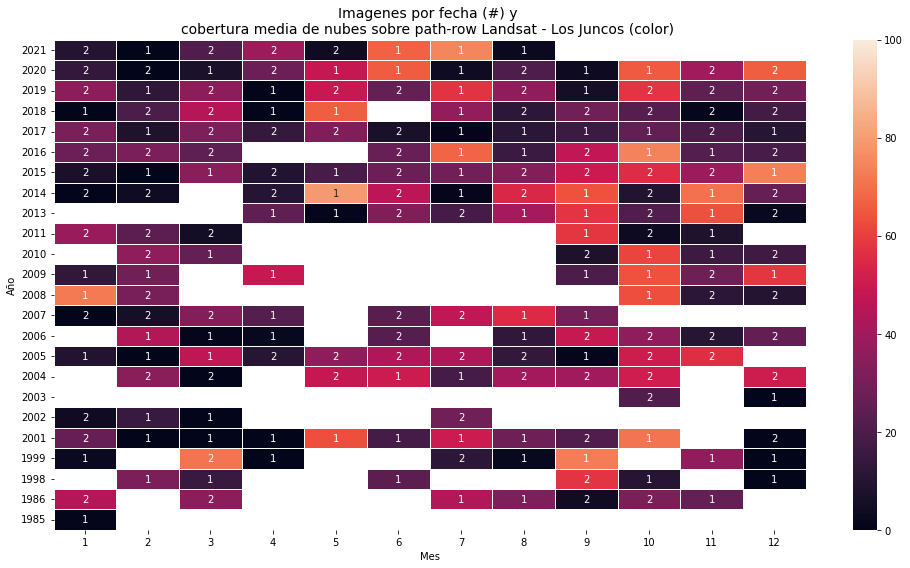

In [4]:
df_=df.groupby(['year','month'])['clouds'].mean().unstack('month').sort_index(ascending=False)
df_anot=df.groupby(['year','month'])['clouds'].count().unstack('month').sort_index(ascending=False)
f,ax=plt.subplots(1,1,figsize=(14,8))
sns.heatmap(df_, annot=df_anot.values,ax=ax,vmin=0,vmax=100,fmt='.0f',linewidths=0.5)
ax.set_title(f'Imagenes por fecha (#) y \ncobertura media de nubes sobre path-row Landsat - Los Juncos (color) ',size=14)
ax.set_xlabel('Mes',size=10)
ax.set_ylabel('Año',size=10)
plt.tight_layout()
plt.savefig('./products/images-by-year.jpg',dpi=300)

### Recortes

In [7]:
IMAGES_RAW='/data/sat-images/los-juncos/'
PROD_INT_DIR='./products/images-crop'
os.makedirs(PROD_INT_DIR,exist_ok=True)
BANDS_L5=['B1','B2','B3','B4','B5']
BANDS_L8=['B2','B3','B4','B5','B6']

In [8]:
client = Client(n_workers=8,threads_per_worker=1,processes=True)
client

<Client: 'tcp://127.0.0.1:44855' processes=8 threads=8, memory=62.65 GiB>

In [9]:
#
l5=LandsatLoader(IMAGES_RAW,bands=BANDS_L5,spacecraft=5)
l8=LandsatLoader(IMAGES_RAW,bands=BANDS_L8,spacecraft=8)
#

@delayed
def raster_pipe(product_id,bbox,folder_proc,bbox_minimal,threshold_value=0.27):
    if 'LT05' in product_id:
        lp=l5
    else:
        lp=l8
    
    res_=lp.execute(product_id,
               bbox=bbox,
               download='skip',
               folder_proc_=folder_proc,
               raster_return_open=False,
               write_file='_idx')
    #
    crs=check_crs(res_['raster_path'])
    cl=get_stats(bbox.to_crs(crs),res_['raster_cloud_path'])
    clm=get_stats(bbox_minimal.to_crs(crs),res_['raster_cloud_path'])
    
    raster=rio.open(res_['raster_path'])
    
    #NDWI
    ndwi=compute_mndwi(raster,idx=[1,3])
    ndwi_name=res_['raster_path'].replace('.TIF','-NDWI.TIF')
    _=write_raster(ndwi_name,ndwi.read(),**ndwi.profile)
    
    mask_ndwi=compute_simple_mask(ndwi,threshold=threshold_value)
    mask_ndwi_path=res_['raster_path'].replace('.TIF','-NDWI-MASK-SIMPLE.TIF')
    _=write_raster(mask_ndwi_path,mask_ndwi.read(),**mask_ndwi.profile)
    cndwi=get_counts(bbox_minimal.to_crs(crs),mask_ndwi.read(1),raster.transform)
    #
    mndwi=compute_mndwi(raster,idx=[1,4])
    mndwi_name=res_['raster_path'].replace('.TIF','-MNDWI.TIF')
    _=write_raster(mndwi_name,mndwi.read(),**mndwi.profile)
    
    mask_mndwi=compute_simple_mask(mndwi,threshold=threshold_value)
    mask_mndwi_path=res_['raster_path'].replace('.TIF','-MNDWI-MASK-SIMPLE.TIF')
    _=write_raster(mask_mndwi_path,mask_mndwi.read(),**mask_mndwi.profile)
    cmndwi=get_counts(bbox_minimal.to_crs(crs),mask_mndwi.read(1),raster.transform)
    #
    raster.close()
    #
    res_.update({'clouds-on-roi':cl,'clouds-on-roi-minimal':clm,
                 'raster_crs':f"EPSG:{crs}",
                 'count-on-roi-minimal-ndwi':cndwi,
                 'count-on-roi-minimal-mndwi':cmndwi,
                 'ndwi_path':ndwi_name,
                 'mask_ndwi_path':mask_ndwi_path,
                 'mndwi_path':mndwi_name,
                 'mask_mndwi_path':mask_mndwi_path,
                 'threshold_value':threshold_value})
    return res_

In [10]:
bbox=gpd.read_file('./data/los-juncos-laguna.geojson')
bbox_minimal=gpd.read_file('./data/los-juncos-laguna-only.geojson')

In [12]:
#
products_dask=[]
for i,r in df.iterrows():
    products_dask.append(raster_pipe(r['product-id'],bbox,PROD_INT_DIR,bbox_minimal,threshold_value=0.25))


In [13]:
dask_products=dask.compute(products_dask)

In [14]:
_dump_json('./products/products-processed.json',dask_products[0])

In [15]:
df_p=pd.DataFrame(dask_products[0])

In [16]:
df_p.head()

raster raster_cloud  match  \
0   None         None  TOTAL   
1   None         None  TOTAL   
2   None         None  TOTAL   
3   None         None  TOTAL   
4   None         None  TOTAL   

                                         raster_path  \
0  ./products/images-crop/LT05_L1TP_231089_198501...   
1  ./products/images-crop/LT05_L1TP_231089_198601...   
2  ./products/images-crop/LT05_L1TP_231089_198601...   
3  ./products/images-crop/LT05_L1TP_231089_198603...   
4  ./products/images-crop/LT05_L1TP_231089_198603...   

                                   raster_cloud_path  clouds-on-roi  \
0  ./products/images-crop/LT05_L1TP_231089_198501...       0.000000   
1  ./products/images-crop/LT05_L1TP_231089_198601...       0.095495   
2  ./products/images-crop/LT05_L1TP_231089_198601...      72.166049   
3  ./products/images-crop/LT05_L1TP_231089_198603...      90.214583   
4  ./products/images-crop/LT05_L1TP_231089_198603...       0.000000   

   clouds-on-roi-minimal  raster_crs  count-on-roi-minimal-ndwi  \
0               0.000000  EPSG:32719                        154   
1               0.000000  EPSG:32719                         42   
2             100.000000  EPSG:32719                          0   
3              98.476454  EPSG:32719                          6   
4               0.000000  EPSG:32719                         67   

   count-on-roi-minimal-mndwi  \
0                          23   
1                          17   
2                           0   
3                           0   
4                           9   

                                           ndwi_path  \
0  ./products/images-crop/LT05_L1TP_231089_198501...   
1  ./products/images-crop/LT05_L1TP_231089_198601...   
2  ./products/images-crop/LT05_L1TP_231089_198601...   
3  ./products/images-crop/LT05_L1TP_231089_198603...   
4  ./products/images-crop/LT05_L1TP_231089_198603...   

                                      mask_ndwi_path  \
0  ./products/images-crop/LT05_L1TP_231089_198501...   
1  ./products/images-crop/LT05_L1TP_231089_198601...   
2  ./products/images-crop/LT05_L1TP_231089_198601...   
3  ./products/images-crop/LT05_L1TP_231089_198603...   
4  ./products/images-crop/LT05_L1TP_231089_198603...   

                                          mndwi_path  \
0  ./products/images-crop/LT05_L1TP_231089_198501...   
1  ./products/images-crop/LT05_L1TP_231089_198601...   
2  ./products/images-crop/LT05_L1TP_231089_198601...   
3  ./products/images-crop/LT05_L1TP_231089_198603...   
4  ./products/images-crop/LT05_L1TP_231089_198603...   

                                     mask_mndwi_path  threshold_value  
0  ./products/images-crop/LT05_L1TP_231089_198501...             0.25  
1  ./products/images-crop/LT05_L1TP_231089_198601...             0.25  
2  ./products/images-crop/LT05_L1TP_231089_198601...             0.25  
3  ./products/images-crop/LT05_L1TP_231089_198603...             0.25  
4  ./products/images-crop/LT05_L1TP_231089_198603...             0.25

In [28]:
df_p.to_csv('./products/products-processed-dataframe.csv',index=False)

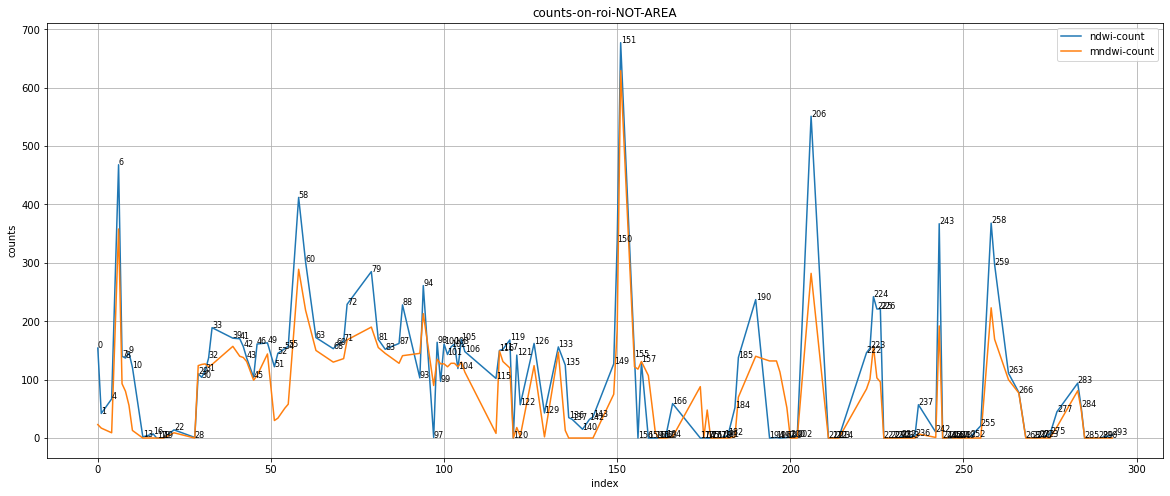

In [18]:
ax=df_p[df_p['clouds-on-roi-minimal']==0]['count-on-roi-minimal-ndwi'].plot(figsize=(20,8))
df_p[df_p['clouds-on-roi-minimal']==0]['count-on-roi-minimal-mndwi'].plot(ax=ax)
ax.set_title('counts-on-roi-NOT-AREA')
ax.set_xlabel('index')
ax.set_ylabel('counts')
for i,r in df_p[df_p['clouds-on-roi-minimal']==0].iterrows():
    ax.text(i,r['count-on-roi-minimal-ndwi'],i,fontsize=8)
ax.legend(['ndwi-count','mndwi-count'])
ax.grid(True)

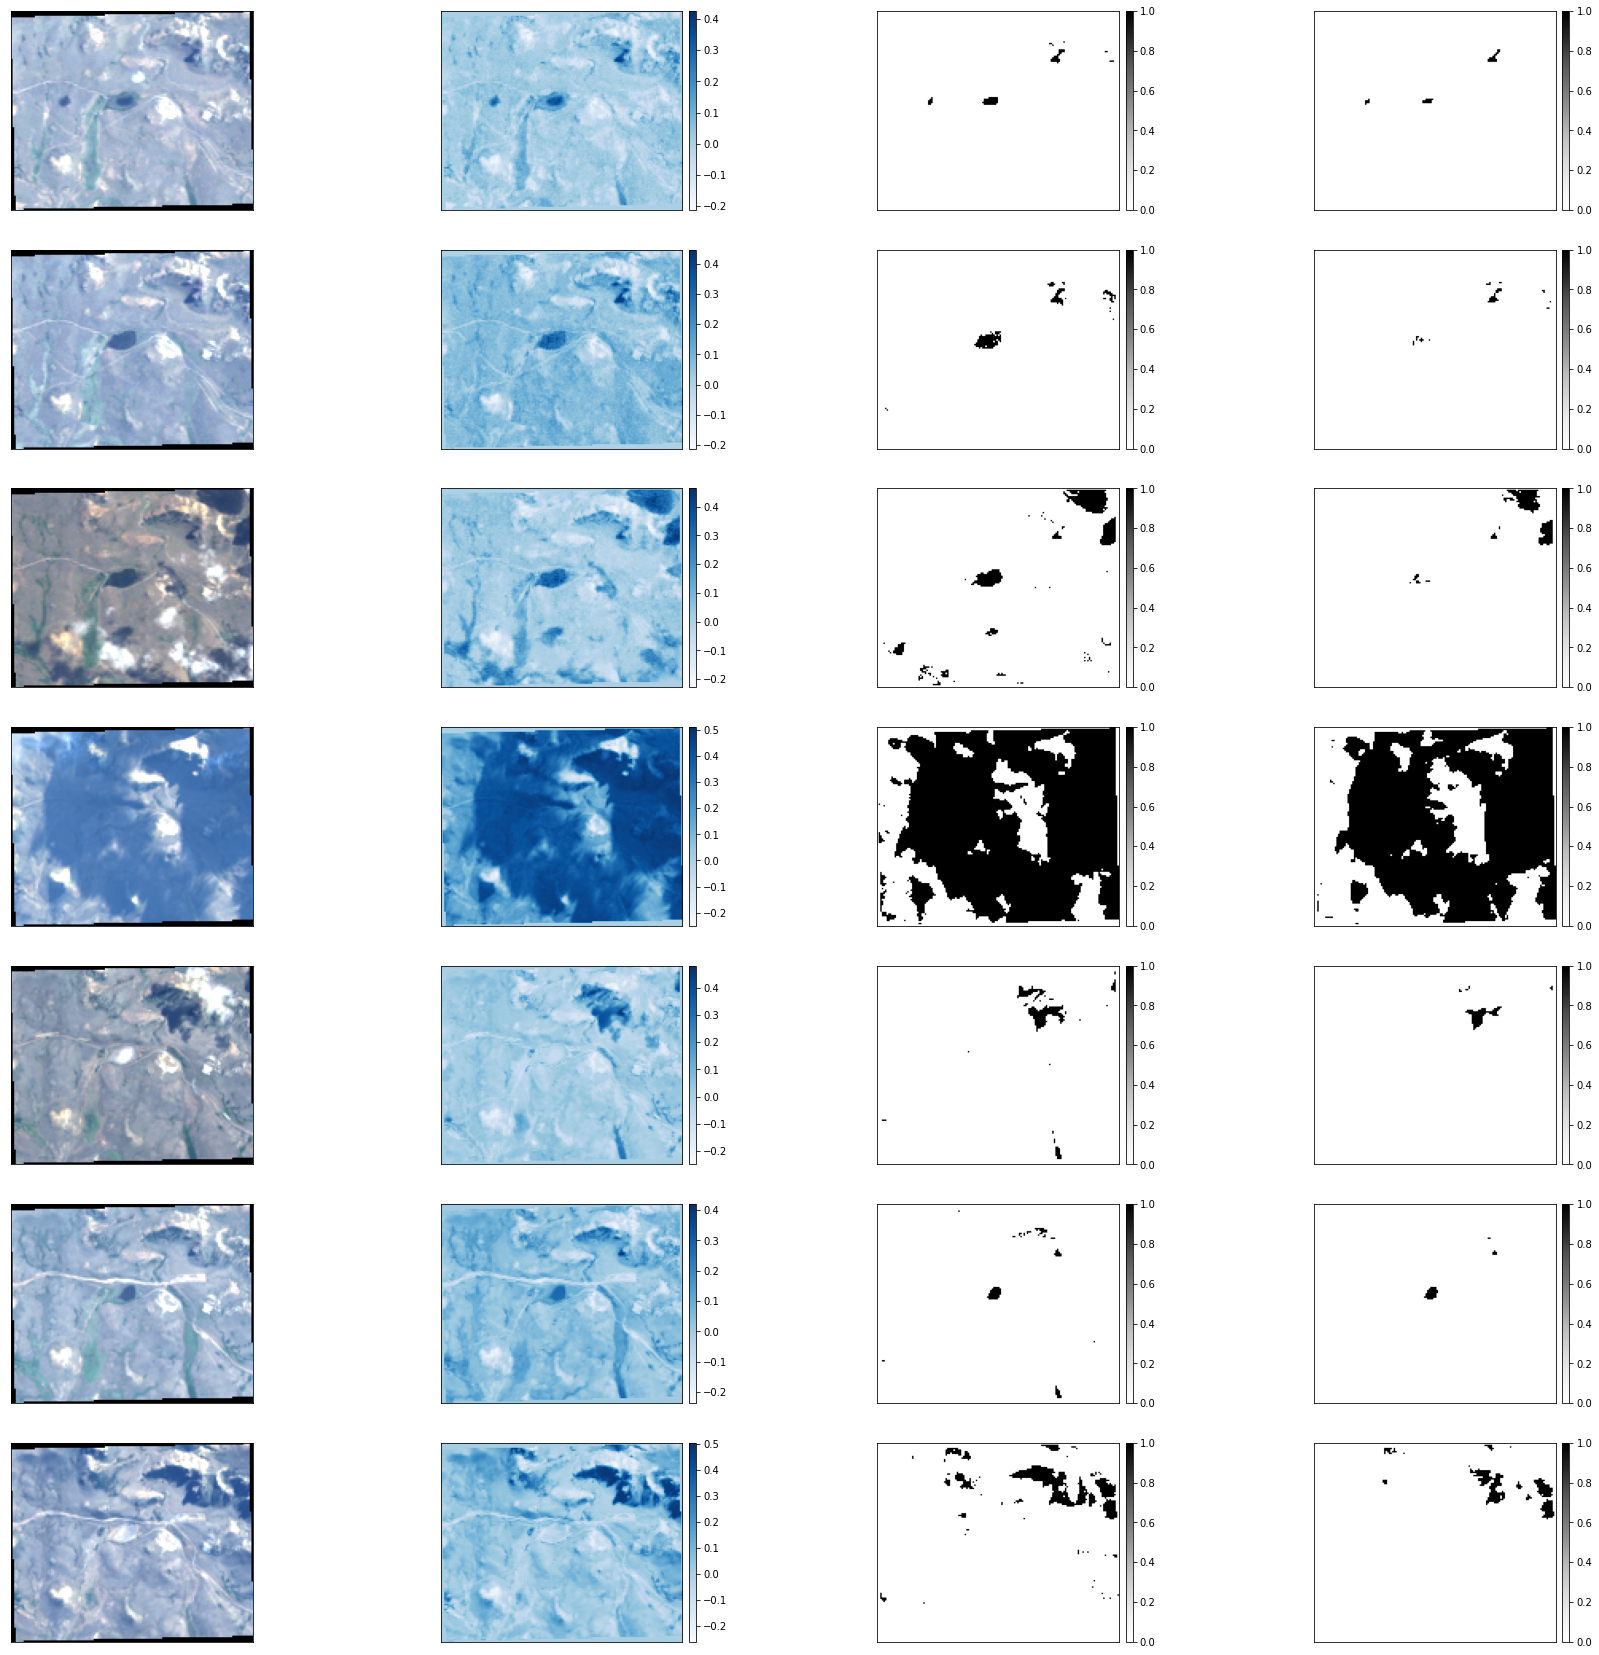

In [19]:
pick_files=[1,10,121,151,214,284,293]
f,ax=plt.subplots(7,4,figsize=(30,30))
j=0
for i, r in df_p.iloc[pick_files].iterrows():
    raster=rio.open(r['raster_path'])
    plot.plot_rgb(raster.read(),ax=ax[j,0],rgb=(2,1,0),stretch=True)
    raster.close()
    raster=rio.open(r['ndwi_path'])
    plot.plot_bands(raster.read(),ax=ax[j,1],cmap='Blues')
    raster.close()
    raster=rio.open(r['mask_ndwi_path'])
    plot.plot_bands(raster.read(),ax=ax[j,2],cmap='Greys')
    raster.close()
    raster=rio.open(r['mask_mndwi_path'])
    plot.plot_bands(raster.read(),ax=ax[j,3],cmap='Greys')
    raster.close()
    j+=1

In [20]:
df_p.iloc[pick_files]

raster raster_cloud  match  \
1     None         None  TOTAL   
10    None         None  TOTAL   
121   None         None  TOTAL   
151   None         None  TOTAL   
214   None         None  TOTAL   
284   None         None  TOTAL   
293   None         None  TOTAL   

                                           raster_path  \
1    ./products/images-crop/LT05_L1TP_231089_198601...   
10   ./products/images-crop/LT05_L1TP_231089_198610...   
121  ./products/images-crop/LT05_L1TP_231089_200901...   
151  ./products/images-crop/LC08_L1TP_231089_201306...   
214  ./products/images-crop/LC08_L1TP_231089_201701...   
284  ./products/images-crop/LC08_L1TP_231089_202011...   
293  ./products/images-crop/LC08_L1TP_231089_202104...   

                                     raster_cloud_path  clouds-on-roi  \
1    ./products/images-crop/LT05_L1TP_231089_198601...       0.095495   
10   ./products/images-crop/LT05_L1TP_231089_198610...       0.000000   
121  ./products/images-crop/LT05_L1TP_231089_200901...      22.548028   
151  ./products/images-crop/LC08_L1TP_231089_201306...      24.238850   
214  ./products/images-crop/LC08_L1TP_231089_201701...       5.718459   
284  ./products/images-crop/LC08_L1TP_231089_202011...       0.000000   
293  ./products/images-crop/LC08_L1TP_231089_202104...       0.000000   

     clouds-on-roi-minimal  raster_crs  count-on-roi-minimal-ndwi  \
1                      0.0  EPSG:32719                         42   
10                     0.0  EPSG:32719                        121   
121                    0.0  EPSG:32719                        142   
151                    0.0  EPSG:32719                        677   
214                    0.0  EPSG:32719                          1   
284                    0.0  EPSG:32719                         53   
293                    0.0  EPSG:32719                          5   

     count-on-roi-minimal-mndwi  \
1                            17   
10                           13   
121                          18   
151                         629   
214                           0   
284                          49   
293                           0   

                                             ndwi_path  \
1    ./products/images-crop/LT05_L1TP_231089_198601...   
10   ./products/images-crop/LT05_L1TP_231089_198610...   
121  ./products/images-crop/LT05_L1TP_231089_200901...   
151  ./products/images-crop/LC08_L1TP_231089_201306...   
214  ./products/images-crop/LC08_L1TP_231089_201701...   
284  ./products/images-crop/LC08_L1TP_231089_202011...   
293  ./products/images-crop/LC08_L1TP_231089_202104...   

                                        mask_ndwi_path  \
1    ./products/images-crop/LT05_L1TP_231089_198601...   
10   ./products/images-crop/LT05_L1TP_231089_198610...   
121  ./products/images-crop/LT05_L1TP_231089_200901...   
151  ./products/images-crop/LC08_L1TP_231089_201306...   
214  ./products/images-crop/LC08_L1TP_231089_201701...   
284  ./products/images-crop/LC08_L1TP_231089_202011...   
293  ./products/images-crop/LC08_L1TP_231089_202104...   

                                            mndwi_path  \
1    ./products/images-crop/LT05_L1TP_231089_198601...   
10   ./products/images-crop/LT05_L1TP_231089_198610...   
121  ./products/images-crop/LT05_L1TP_231089_200901...   
151  ./products/images-crop/LC08_L1TP_231089_201306...   
214  ./products/images-crop/LC08_L1TP_231089_201701...   
284  ./products/images-crop/LC08_L1TP_231089_202011...   
293  ./products/images-crop/LC08_L1TP_231089_202104...   

                                       mask_mndwi_path  threshold_value  
1    ./products/images-crop/LT05_L1TP_231089_198601...             0.25  
10   ./products/images-crop/LT05_L1TP_231089_198610...             0.25  
121  ./products/images-crop/LT05_L1TP_231089_200901...             0.25  
151  ./products/images-crop/LC08_L1TP_231089_201306...             0.25  
214  ./products/images-crop/LC08_L1TP_231089_201701...             0.25  
284  ./p

Notemos que en los casos de ejemplo planteados, la presencia de nubes (sombras en este caso) impacta severamente en la cuenta (indice 151).

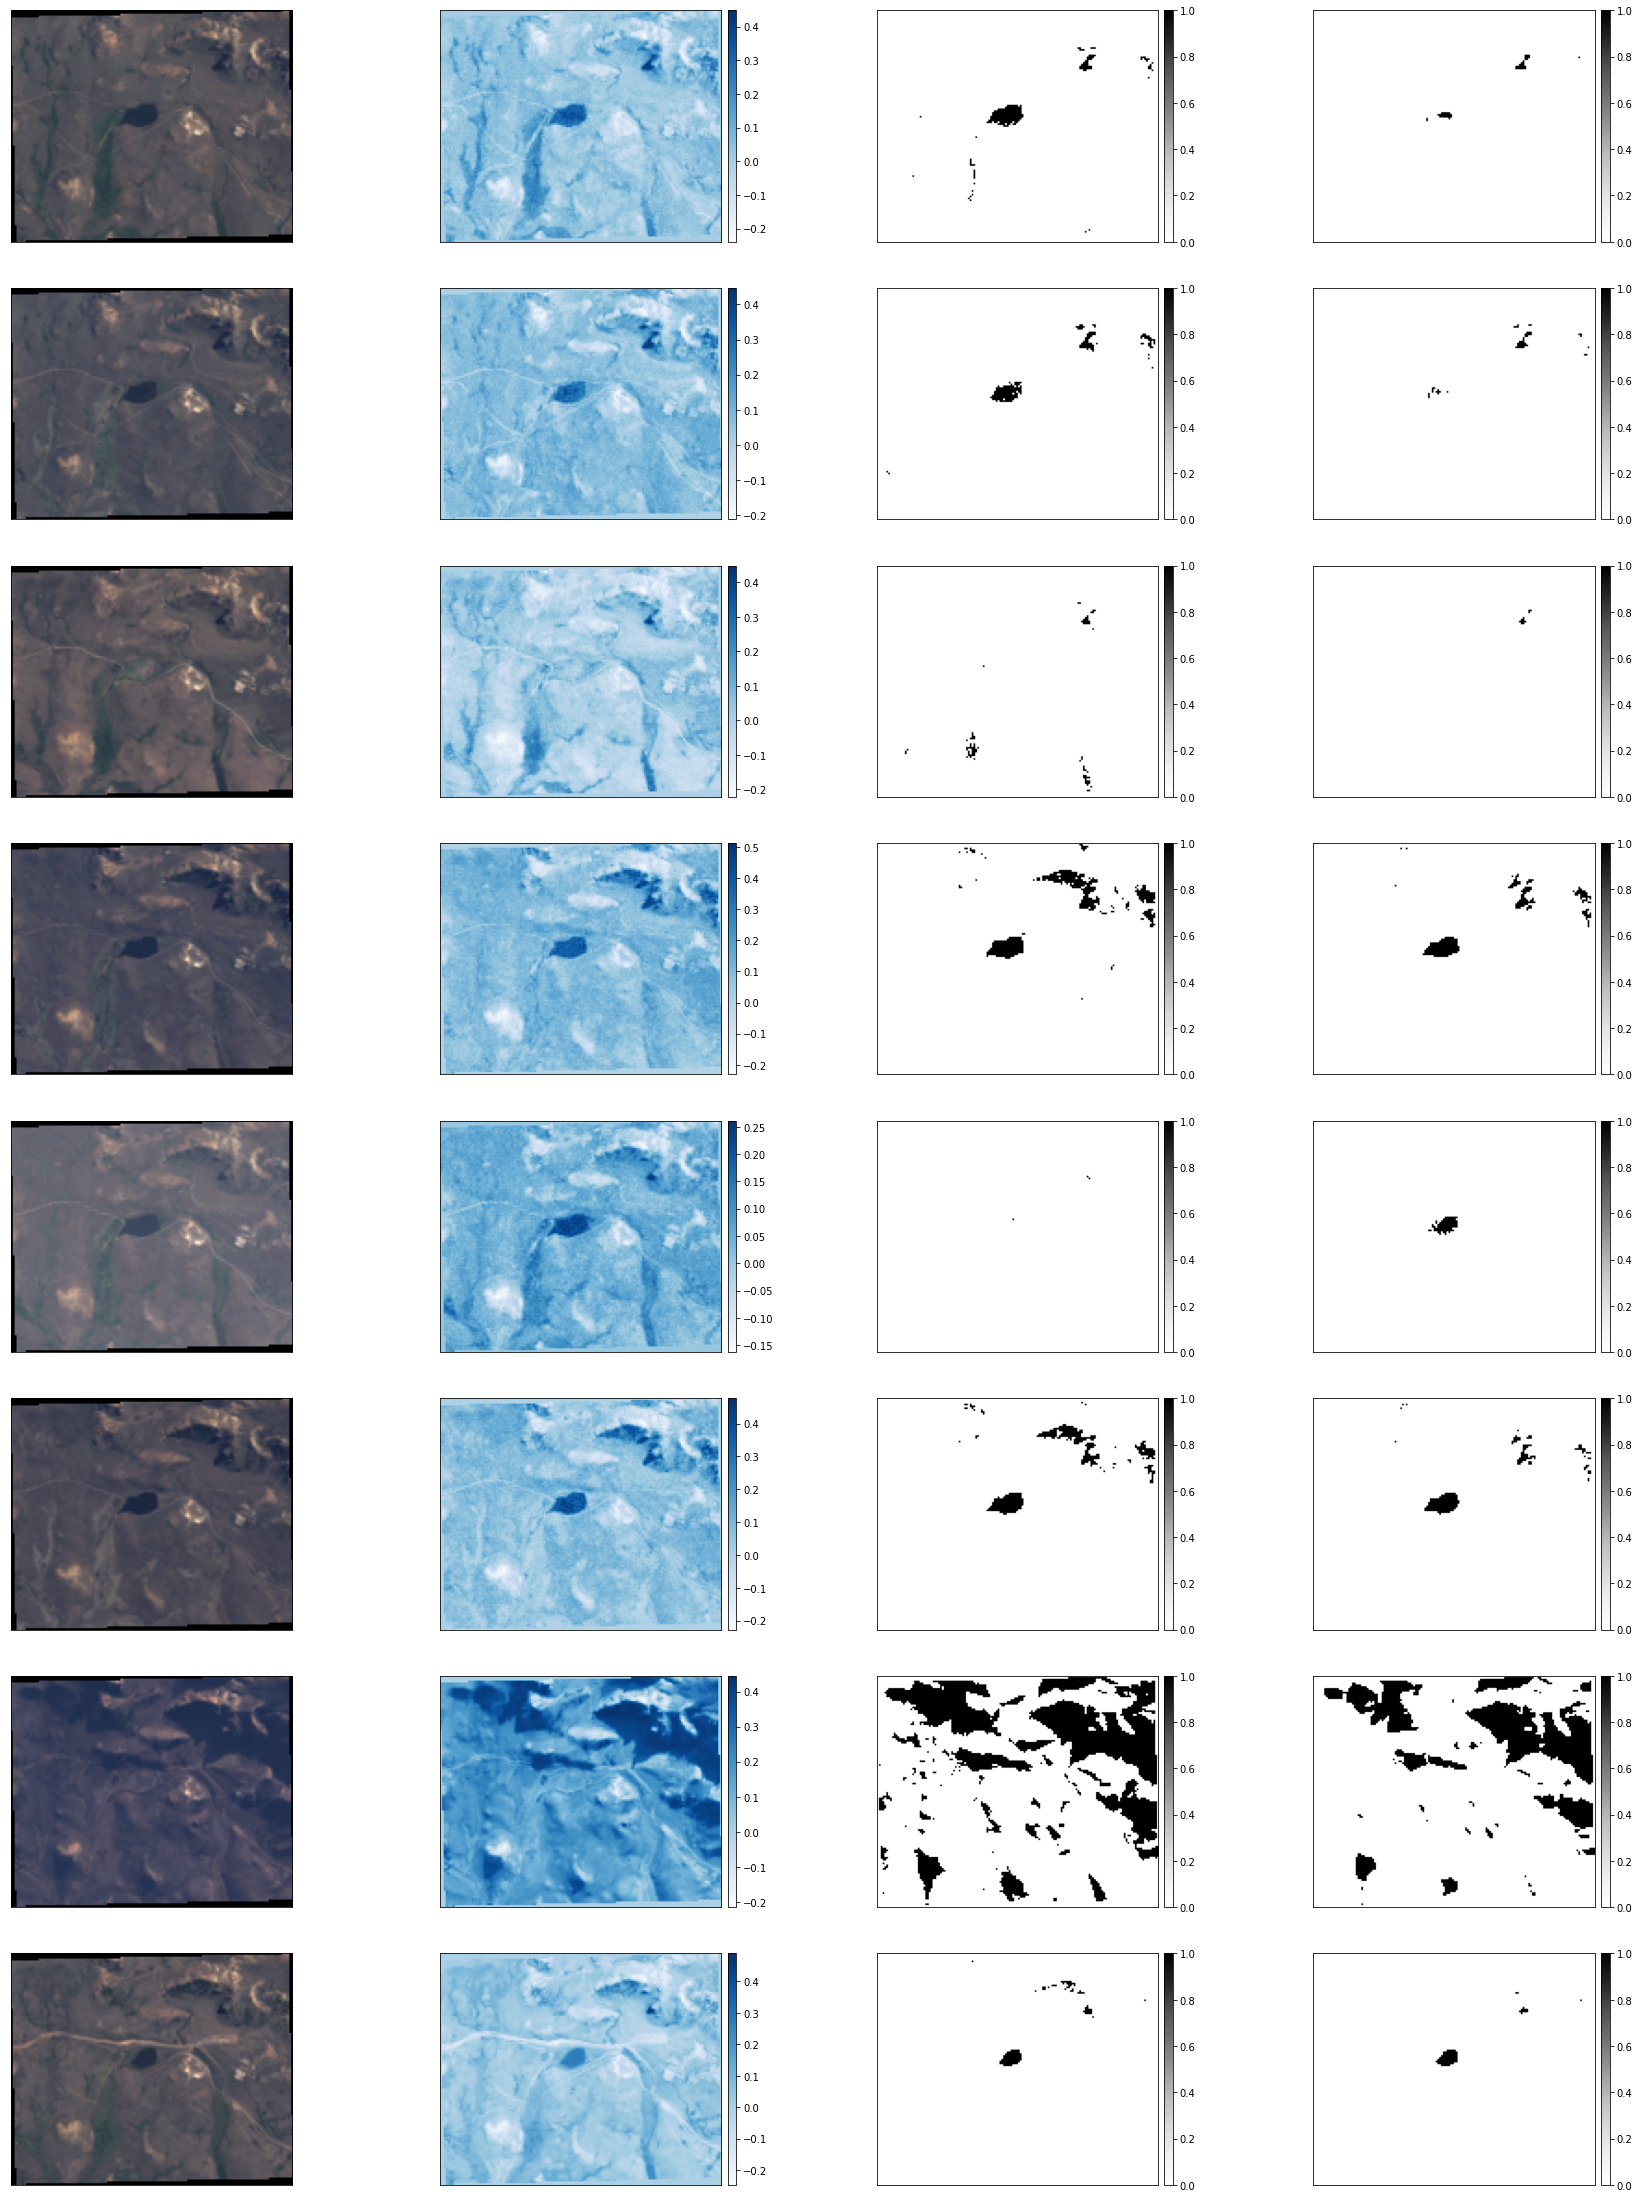

In [21]:
pick_files=[0,10,28,63,97,133,223,266]
f,ax=plt.subplots(8,4,figsize=(30,40))
j=0
for i, r in df_p.iloc[pick_files].iterrows():
    raster=rio.open(r['raster_path'])
    plot.plot_rgb(raster.read(),ax=ax[j,0],rgb=(2,1,0))
    raster.close()
    raster=rio.open(r['ndwi_path'])
    plot.plot_bands(raster.read(),ax=ax[j,1],cmap='Blues')
    raster.close()
    raster=rio.open(r['mask_ndwi_path'])
    plot.plot_bands(raster.read(),ax=ax[j,2],cmap='Greys')
    raster.close()
    raster=rio.open(r['mask_mndwi_path'])
    plot.plot_bands(raster.read(),ax=ax[j,3],cmap='Greys')
    raster.close()
    j+=1

In [22]:
df_p.iloc[pick_files]

raster raster_cloud  match  \
0     None         None  TOTAL   
10    None         None  TOTAL   
28    None         None  TOTAL   
63    None         None  TOTAL   
97    None         None  TOTAL   
133   None         None  TOTAL   
223   None         None  TOTAL   
266   None         None  TOTAL   

                                           raster_path  \
0    ./products/images-crop/LT05_L1TP_231089_198501...   
10   ./products/images-crop/LT05_L1TP_231089_198610...   
28   ./products/images-crop/LT05_L1TP_231089_199912...   
63   ./products/images-crop/LT05_L1TP_231089_200409...   
97   ./products/images-crop/LT05_L1TP_231089_200611...   
133  ./products/images-crop/LT05_L1TP_231089_201009...   
223  ./products/images-crop/LC08_L1TP_231089_201706...   
266  ./products/images-crop/LC08_L1TP_231089_201911...   

                                     raster_cloud_path  clouds-on-roi  \
0    ./products/images-crop/LT05_L1TP_231089_198501...            0.0   
10   ./products/images-crop/LT05_L1TP_231089_198610...            0.0   
28   ./products/images-crop/LT05_L1TP_231089_199912...            0.0   
63   ./products/images-crop/LT05_L1TP_231089_200409...            0.0   
97   ./products/images-crop/LT05_L1TP_231089_200611...            0.0   
133  ./products/images-crop/LT05_L1TP_231089_201009...            0.0   
223  ./products/images-crop/LC08_L1TP_231089_201706...            0.0   
266  ./products/images-crop/LC08_L1TP_231089_201911...            0.0   

     clouds-on-roi-minimal  raster_crs  count-on-roi-minimal-ndwi  \
0                      0.0  EPSG:32719                        154   
10                     0.0  EPSG:32719                        121   
28                     0.0  EPSG:32719                          1   
63                     0.0  EPSG:32719                        172   
97                     0.0  EPSG:32719                          1   
133                    0.0  EPSG:32719                        156   
223                    0.0  EPSG:32719                        154   
266                    0.0  EPSG:32719                         78   

     count-on-roi-minimal-mndwi  \
0                            23   
10                           13   
28                            0   
63                          150   
97                           90   
133                         147   
223                         101   
266                          77   

                                             ndwi_path  \
0    ./products/images-crop/LT05_L1TP_231089_198501...   
10   ./products/images-crop/LT05_L1TP_231089_198610...   
28   ./products/images-crop/LT05_L1TP_231089_199912...   
63   ./products/images-crop/LT05_L1TP_231089_200409...   
97   ./products/images-crop/LT05_L1TP_231089_200611...   
133  ./products/images-crop/LT05_L1TP_231089_201009...   
223  ./products/images-crop/LC08_L1TP_231089_201706...   
266  ./products/images-crop/LC08_L1TP_231089_201911...   

                                        mask_ndwi_path  \
0    ./products/images-crop/LT05_L1TP_231089_198501...   
10   ./products/images-crop/LT05_L1TP_231089_198610...   
28   ./products/images-crop/LT05_L1TP_231089_199912...   
63   ./products/images-crop/LT05_L1TP_231089_200409...   
97   ./products/images-crop/LT05_L1TP_231089_200611...   
133  ./products/images-crop/LT05_L1TP_231089_201009...   
223  ./products/images-crop/LC08_L1TP_231089_201706...   
266  ./products/images-crop/LC08_L1TP_231089_201911...   

                                            mndwi_path  \
0    ./products/images-crop/LT05_L1TP_231089_198501...   
10   ./products/images-crop/LT05_L1TP_231089_198610...   
28   ./products/images-crop/LT05_L1TP_231089_199912...   
63   ./products/images-crop/LT05_L1TP_231089_200409...   
97   ./products/images-crop/LT05_L1TP_231089_200611...   
133  ./products/images-crop/LT05_L1TP_231089_201009...   
223  ./products/images-crop/LC08_L1TP_231089_201706...   
266  ./products/images-crop/LC08_L1TP_231089_201911...   

         

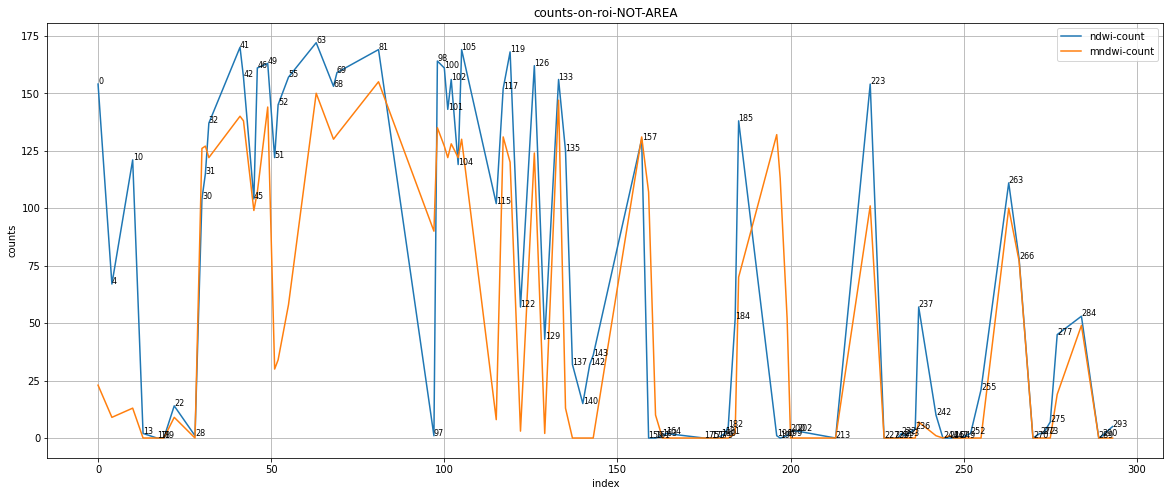

In [23]:
ax=df_p[df_p['clouds-on-roi']==0]['count-on-roi-minimal-ndwi'].plot(figsize=(20,8))
df_p[df_p['clouds-on-roi']==0]['count-on-roi-minimal-mndwi'].plot(ax=ax)
ax.set_title('counts-on-roi-NOT-AREA')
ax.set_xlabel('index')
ax.set_ylabel('counts')
for i,r in df_p[df_p['clouds-on-roi']==0].iterrows():
    ax.text(i,r['count-on-roi-minimal-ndwi'],i,fontsize=8)
ax.legend(['ndwi-count','mndwi-count'])
ax.grid(True)

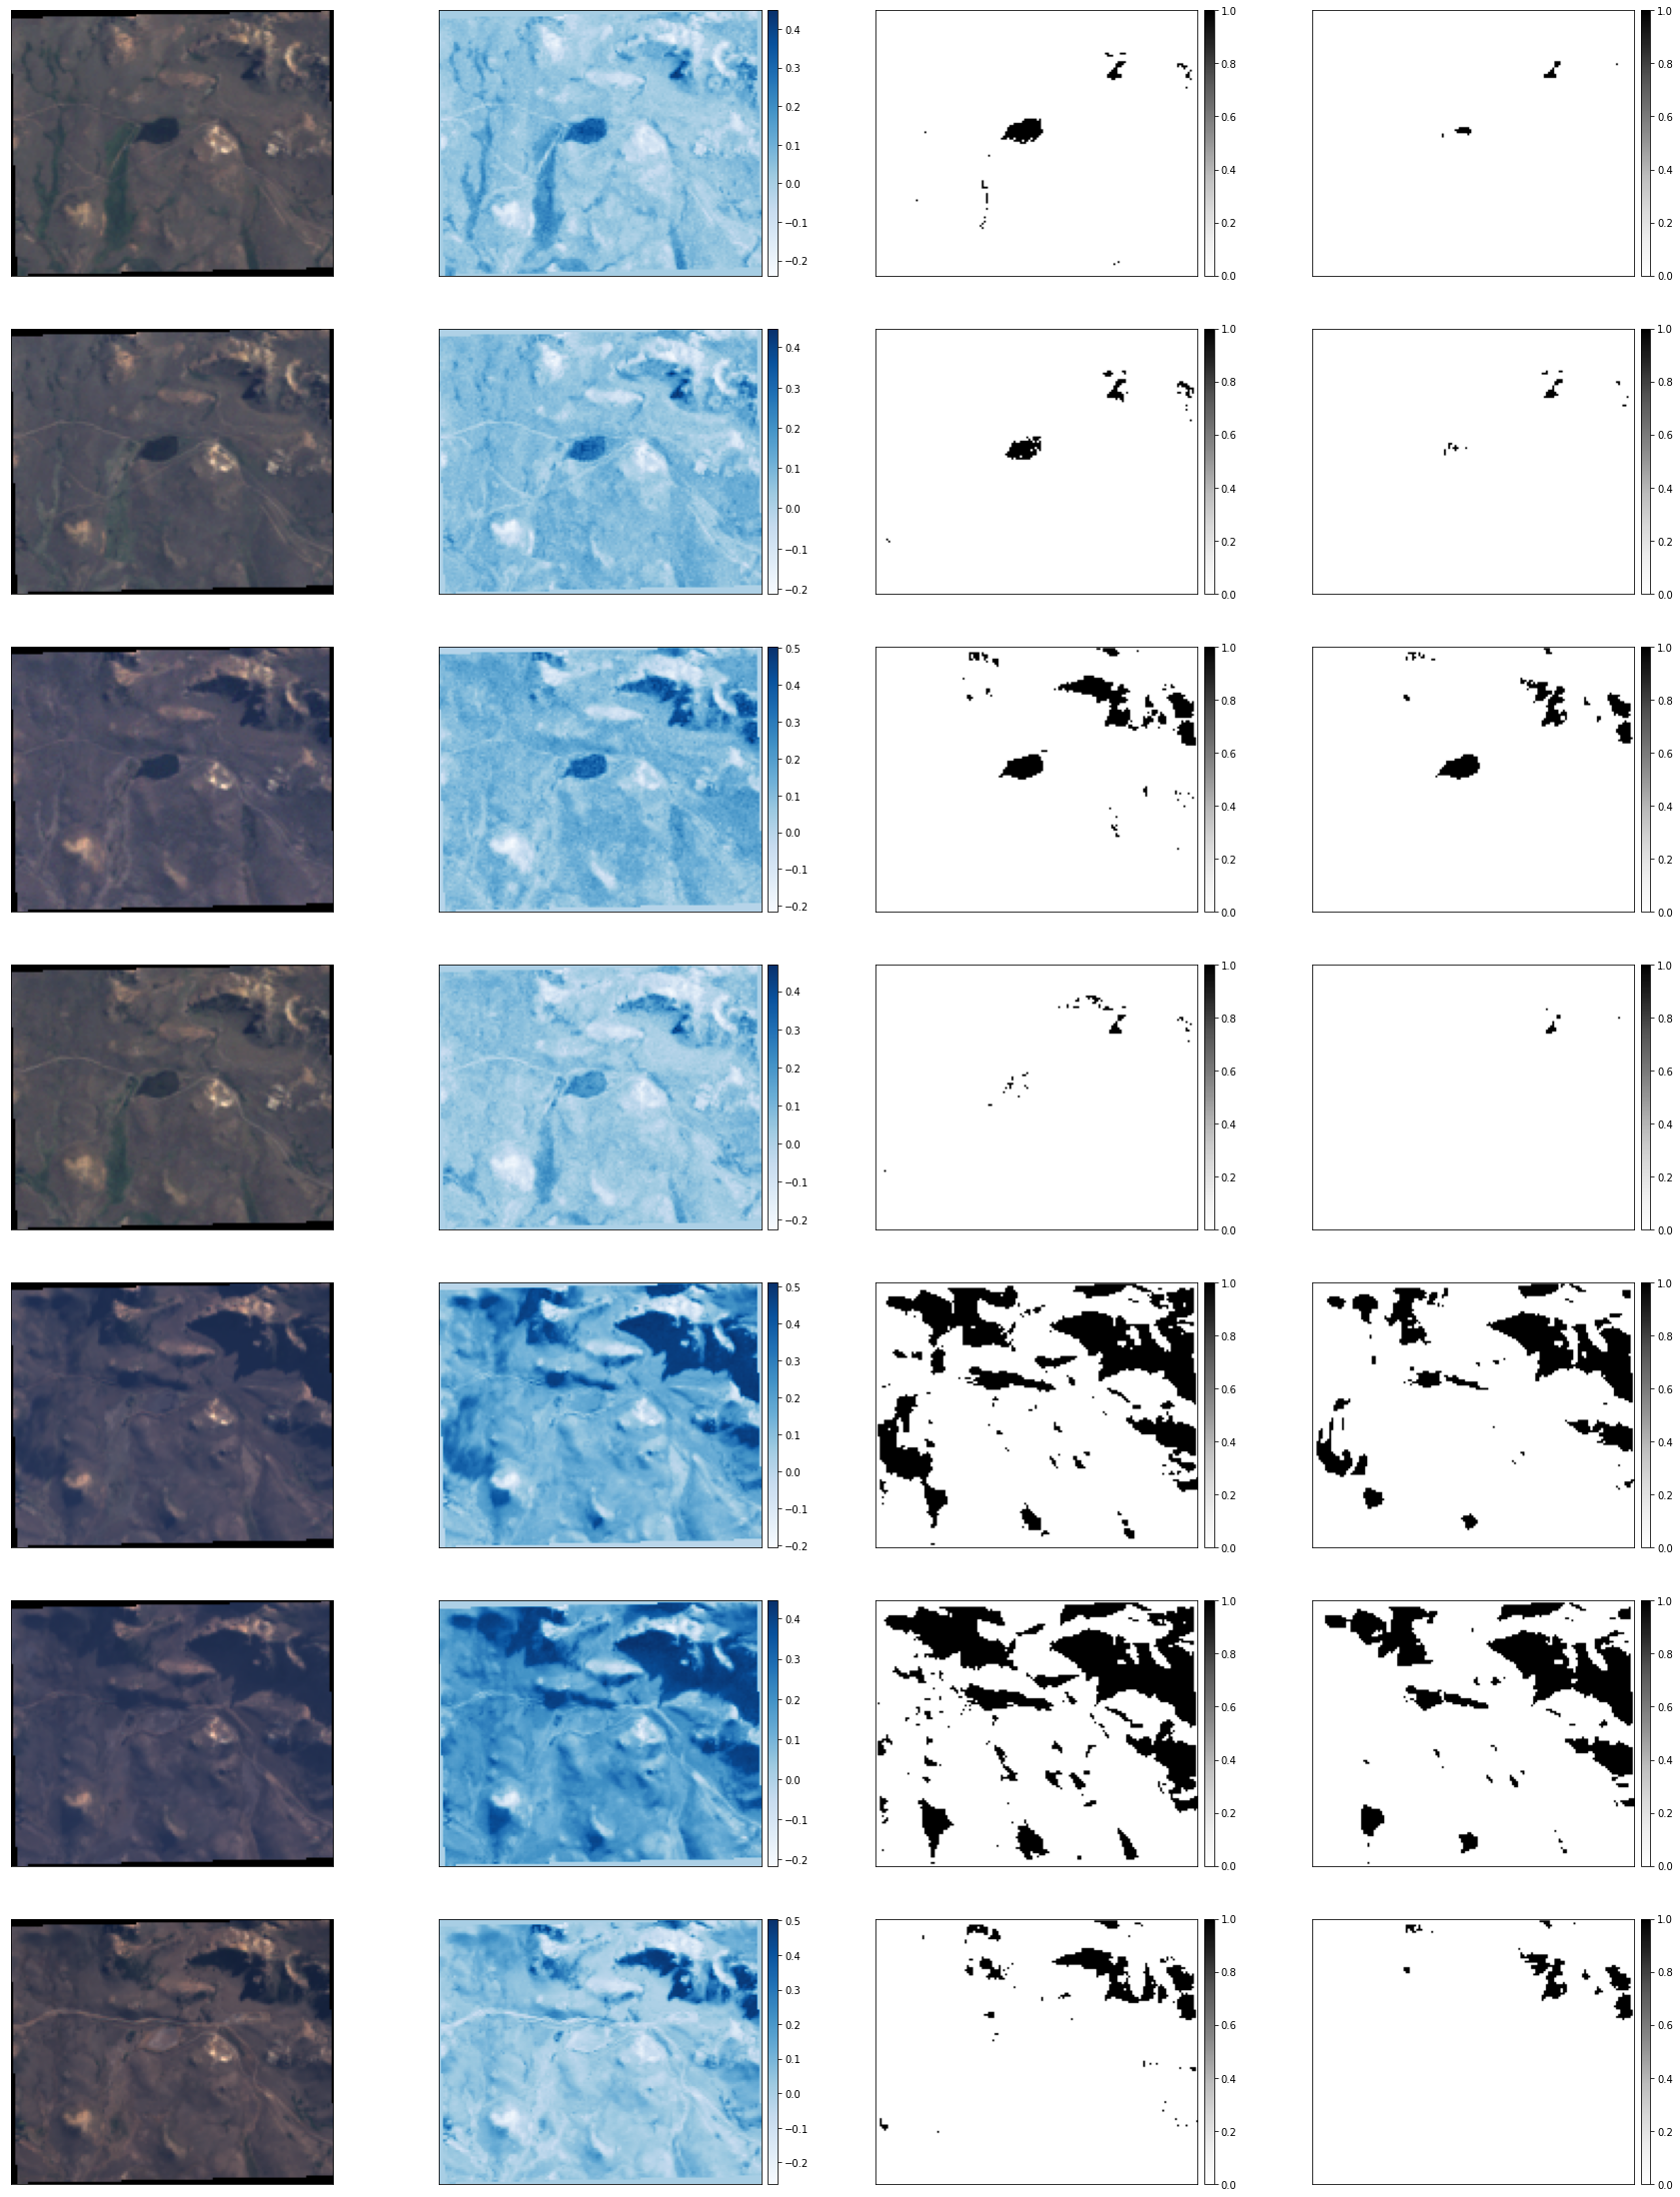

In [24]:
pick_files=[0,10,81,140,185,223,293]
f,ax=plt.subplots(7,4,figsize=(30,40))
j=0
for i, r in df_p.iloc[pick_files].iterrows():
    raster=rio.open(r['raster_path'])
    plot.plot_rgb(raster.read(),ax=ax[j,0],rgb=(2,1,0))
    raster.close()
    raster=rio.open(r['ndwi_path'])
    plot.plot_bands(raster.read(),ax=ax[j,1],cmap='Blues')
    raster.close()
    raster=rio.open(r['mask_ndwi_path'])
    plot.plot_bands(raster.read(),ax=ax[j,2],cmap='Greys')
    raster.close()
    raster=rio.open(r['mask_mndwi_path'])
    plot.plot_bands(raster.read(),ax=ax[j,3],cmap='Greys')
    raster.close()
    j+=1

In [27]:
#ca
df_cat=pd.concat([df.reset_index(drop=True),df_p],axis=1)
df_cat.to_csv('./products/products-processed-dataframe-with-dates.csv',index=False)

In [26]:
df_cat.head(10)

product-id  \
0  LT05_L1TP_231089_19850127_20170219_01_T1   
1  LT05_L1TP_231089_19860114_20170218_01_T1   
2  LT05_L1TP_231089_19860130_20170218_01_T1   
3  LT05_L1TP_231089_19860303_20170218_01_T1   
4  LT05_L1TP_231089_19860319_20170218_01_T1   
5  LT05_L1TP_231089_19860725_20170217_01_T1   
6  LT05_L1TP_231089_19860810_20170216_01_T1   
7  LT05_L1TP_231089_19860911_20170216_01_T1   
8  LT05_L1TP_231089_19860927_20170216_01_T1   
9  LT05_L1TP_231089_19861013_20170216_01_T1   

                                            base-url       date  clouds  \
0  gs://gcp-public-data-landsat/LT05/01/231/089/L... 1985-01-27     1.0   
1  gs://gcp-public-data-landsat/LT05/01/231/089/L... 1986-01-14    21.0   
2  gs://gcp-public-data-landsat/LT05/01/231/089/L... 1986-01-30    68.0   
3  gs://gcp-public-data-landsat/LT05/01/231/089/L... 1986-03-03    67.0   
4  gs://gcp-public-data-landsat/LT05/01/231/089/L... 1986-03-19     4.0   
5  gs://gcp-public-data-landsat/LT05/01/231/089/L... 1986-07-25    44.0   
6  gs://gcp-public-data-landsat/LT05/01/231/089/L... 1986-08-10    32.0   
7  gs://gcp-public-data-landsat/LT05/01/231/089/L... 1986-09-11     8.0   
8  gs://gcp-public-data-landsat/LT05/01/231/089/L... 1986-09-27     1.0   
9  gs://gcp-public-data-landsat/LT05/01/231/089/L... 1986-10-13    60.0   

   month  year raster raster_cloud  match  \
0      1  1985   None         None  TOTAL   
1      1  1986   None         None  TOTAL   
2      1  1986   None         None  TOTAL   
3      3  1986   None         None  TOTAL   
4      3  1986   None         None  TOTAL   
5      7  1986   None         None  TOTAL   
6      8  1986   None         None  TOTAL   
7      9  1986   None         None  TOTAL   
8      9  1986   None         None  TOTAL   
9     10  1986   None         None  TOTAL   

                                         raster_path  ... clouds-on-roi  \
0  ./products/images-crop/LT05_L1TP_231089_198501...  ...      0.000000   
1  ./products/images-crop/LT05_L1TP_231089_198601...  ...      0.095495   
2  ./products/images-crop/LT05_L1TP_231089_198601...  ...     72.166049   
3  ./products/images-crop/LT05_L1TP_231089_198603...  ...     90.214583   
4  ./products/images-crop/LT05_L1TP_231089_198603...  ...      0.000000   
5  ./products/images-crop/LT05_L1TP_231089_198607...  ...      4.392765   
6  ./products/images-crop/LT05_L1TP_231089_198608...  ...      0.275250   
7  ./products/images-crop/LT05_L1TP_231089_198609...  ...      3.106393   
8  ./products/images-crop/LT05_L1TP_231089_198609...  ...      0.044939   
9  ./products/images-crop/LT05_L1TP_231089_198610...  ...     14.155713   

   clouds-on-roi-minimal  raster_crs count-on-roi-minimal-ndwi  \
0               0.000000  EPSG:32719                       154   
1               0.000000  EPSG:32719                        42   
2             100.000000  EPSG:32719                         0   
3              98.476454  EPSG:32719                         6   
4               0.000000  EPSG:32719                        67   
5              16.620499  EPSG:32719                         2   
6               0.000000  EPSG:32719                       468   
7               0.000000  EPSG:32719                       140   
8               0.000000  EPSG:32719                       137   
9               0.000000  EPSG:32719                       146   

   count-on-roi-minimal-mndwi  \
0                          23   
1                          17   
2                           0   
3                           0   
4                           9   
5                           0   
6                         358   
7                          93   
8                          80   
9                          56   

                                           ndwi_path  \
0  ./products/images-crop/LT05_L1TP_231089_198501...   
1  ./products/images-crop/LT05_L1TP_231089_198601...   
2  ./products/images-crop/LT05_L1TP_231089_198601...   
3  ./products/images-crop/LT05_L1TP_231089_198603...

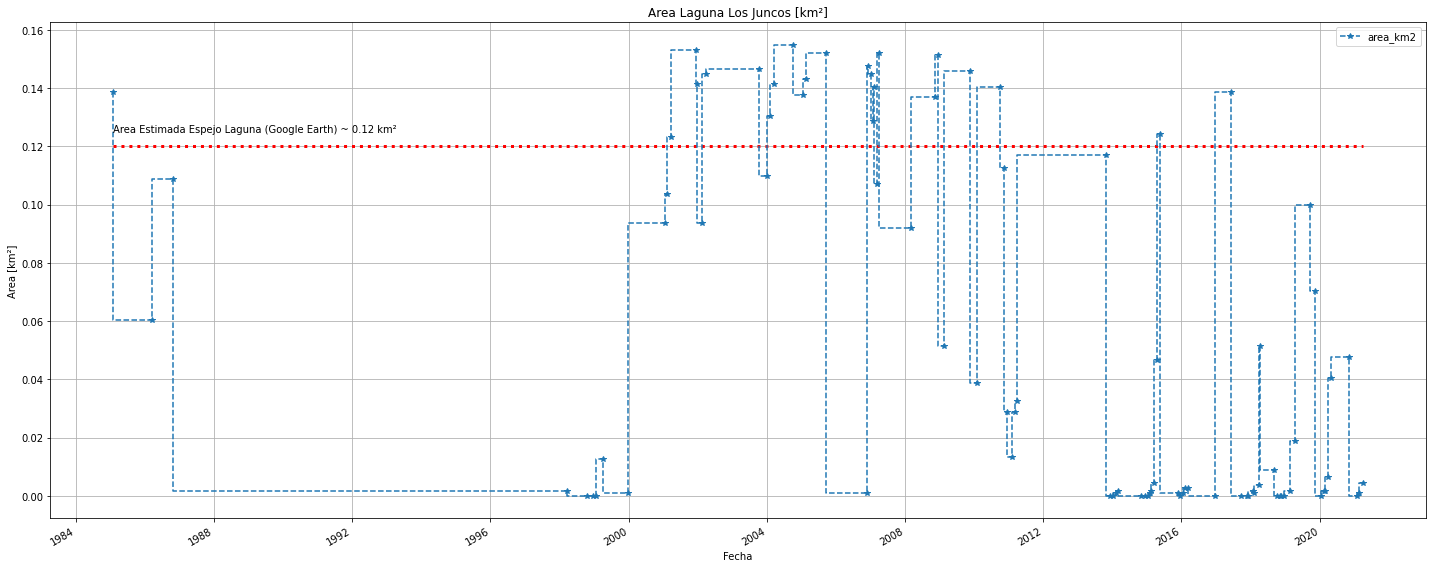

In [39]:
f,ax=plt.subplots(1,1,figsize=(20,8))
df_cat['area_km2']=df_cat['count-on-roi-minimal-ndwi']*30**2/(1000**2)
df_cat[df_cat['clouds-on-roi']==0].plot(x='date',y='area_km2',ax=ax,ls='--',drawstyle="steps-pre",marker='*')
plt.grid(True)
ax.set_xlabel('Fecha')
ax.set_ylabel('Area [km²]')
ax.set_title('Area Laguna Los Juncos [km²]')
ax.hlines(0.12,df_cat[df_cat['clouds-on-roi']==0].date.iloc[0],df_cat[df_cat['clouds-on-roi']==0].date.iloc[-1],colors='r',ls=':',lw=3)
ax.text(df_cat[df_cat['clouds-on-roi']==0].date.iloc[0],0.125,f'Area Estimada Espejo Laguna (Google Earth) ~ {np.pi*(150)*(250)/1000**2:0.2f} km²')
plt.tight_layout()
plt.savefig('./products/area-laguna-los-juncos.jpg',dpi=300)

In [67]:
# make delayed
delayed_plot=delayed(process_pipeline_plots)
IMAGES='./products/image'
os.makedirs(IMAGES,exist_ok=True)

In [68]:
tasks=[]
for i,r in df_cat.iterrows():
    tasks.append(delayed_plot(r['raster_path'],rgb_list=[(2, 1, 0), (3, 4, 2)],out_images_base=IMAGES))

In [69]:
images_tasks=dask.compute(tasks)

In [70]:
images_tasks_cat=['#'.join(l) for l in images_tasks[0]]

In [71]:
df_cat['images']= images_tasks_cat
df_cat.to_csv('./products/products-processed-dataframe-with-dates-with-images.csv',index=False)

### Animacion

In [72]:
import imageio,glob

gif_path='./products/Los-Juncos-TimeEvolution-RGB.gif'

images=[]
img=[l.split("#")[0] for l in df_cat[df_cat['clouds-on-roi']==0]['images'].values]
for im in img:
    images.append(imageio.imread(im))
imageio.mimsave(gif_path, images,fps=3)

In [73]:
gif_path='./products/Los-Juncos-TimeEvolution-FalseColor0.gif'

images=[]
img=[l.split("#")[1] for l in df_cat[df_cat['clouds-on-roi']==0]['images'].values]
for im in img:
    images.append(imageio.imread(im))
imageio.mimsave(gif_path, images,fps=3)

## Ciclado

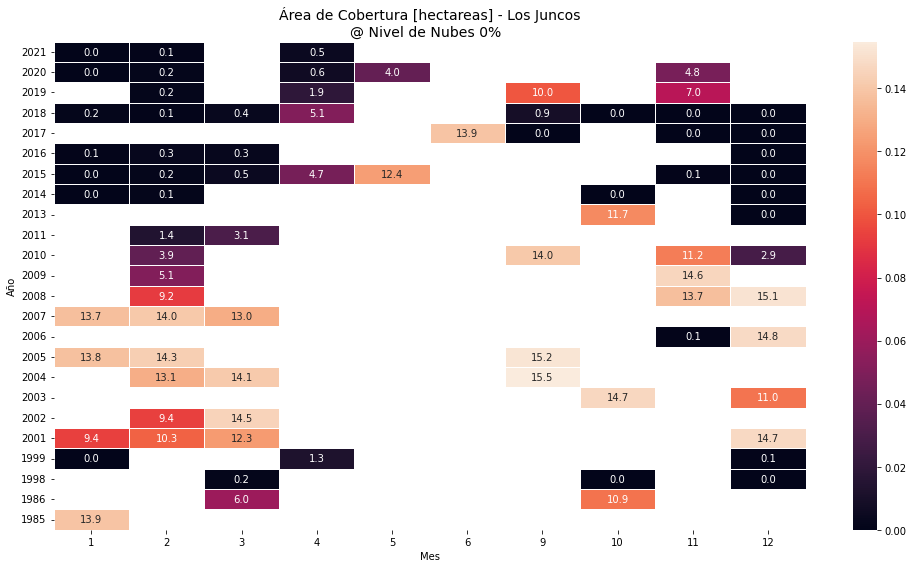

In [96]:
df_cat['area_ht']=df_cat['count-on-roi-minimal-ndwi']*30**2/(100**2)
df_filt=df_cat[df_cat['clouds-on-roi']==0]
df_=df_filt.groupby(['year','month'])['area_km2'].mean().unstack('month').sort_index(ascending=False)
df_anot=df_filt.groupby(['year','month'])['area_ht'].mean().unstack('month').sort_index(ascending=False)
f,ax=plt.subplots(1,1,figsize=(14,8))
sns.heatmap(df_, annot=df_anot.values,ax=ax,fmt='.1f',linewidths=0.5)
ax.set_title(f'Área de Cobertura [hectareas] - Los Juncos\n@ Nivel de Nubes 0%  ',size=14)
ax.set_xlabel('Mes',size=10)
ax.set_ylabel('Año',size=10);
plt.tight_layout()
plt.savefig('./products/area-laguna-los-juncos-hectareas-evolucion-mes.jpg',dpi=300)